# Fingerprint Left or Right Hand Prediction

## About the data
Sokoto Coventry Fingerprint Dataset (SOCOFing) is a biometric fingerprint database designed for academic research purposes. SOCOFing is made up of 6,000 fingerprint images from 600 African subjects and contains unique attributes such as labels for gender, hand and finger name as well as synthetically altered versions with three different levels of alteration for obliteration, central rotation, and z-cut. For a complete formal description and usage policy please refer to the following paper: https://arxiv.org/abs/1807.10609.

## About the Demo
This notebook was built to demonstrate the value of utilizing AWS SageMaker for Model development/training and Red Hat OpenShift on AWS for Model deployment/serving.

## About the notebook
The intention of this notebook is to demonstrate steps from data ingestion to model saving that provides an accurate enough model that predicts if a fingerprint comes from a left or right hand. Coupled with other models that accurately predict finger and gender is valuable when matching against other identifiable information.

1. *Data Ingestion* [from object storage](#working-with-s3-buckets)
1. *Dataset preparation* (infer labels, splitting, augmenting, optimizing)
1. *Model Development* from scratch and *Training Strategies* (one device, mirrored, multi-worker mirrored)
1. *Model Performance* Hyperparameter Tuning strategies (RandomSearch, Hyperband, BayesianOptimization, Sklearn)
1. *Model Serialization* to object storage
1. *Prediction Sampling*

### Notebook Tested Requirements

|Notebook origin|Notebook Customization|Instance Type|Kernel|TensorFlow|Runtime|
|:-------|:-------|:-------|:-------|:-------|:-------|
|SageMaker Notebook Instances|[from GitHub](https://github.com/redhat-na-ssa/demo-rosa-sagemaker/blob/main/sagemaker/lifecycle-from-github.sh)|ml.m5.4xlarge (vCPU: 16, RAM: 64 GiB)|conda_tensorflow2_p310|2.11|~120 minutes|
|SageMaker Notebook Instances|[from GitHub](https://github.com/redhat-na-ssa/demo-rosa-sagemaker/blob/main/sagemaker/lifecycle-from-github.sh)|ml.p3.8xlarge (vCPU: 32, RAM: 244 GiB)|conda_tensorflow2_p310|2.11|~15 minutes|

# Setup

In [1]:
# source the setup Bash script to run specific configuration tasks
! source ../setup.sh && setup_dataset && install_requirements


You can run individual functions!

example:
  setup_demo

Pulling dataset from https://github.com/redhat-na-ssa/datasci-fingerprint-data.git...
exists
tar: Ignoring unknown extended header keyword 'SCHILY.fflags'


In [2]:
# Install packages and frameworks
import tensorflow as tf
import os

# debugging code "Cleanup Called..." gets displayed if get_logger is not set
# the below code suppresses the "Cleanup Called..." output
tf.get_logger().setLevel('INFO')

# expecting 2.11
# if 2.7, than logging errors will show "Cleanup called..."
print(tf.__version__)

2023-05-31 22:12:16.370048: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-31 22:12:16.504320: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-31 22:12:17.425799: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-05-31 22:12:17.425880: W tensorflow/

2.11.1


If this is your first time running the notebook, you may need to restart the kernel after the Tensorflow upgrade

# Data Preparation

## Create local directory structure

- scratch: ignored by git; keep data out of git
- models: saved models
- real: "real" fingerprint samples
- tune: hyperparameter trials results
- train: decompressed training examples

In [3]:
# scratch directory is apart of the .gitignore to ensure it is not committed to git
# see setup.sh (setup_dataset)
%env SCRATCH=../scratch
! [ -e "${SCRATCH}" ] || mkdir -p "${SCRATCH}"

scratch_path = os.environ.get('SCRATCH', './scratch')

env: SCRATCH=../scratch


### Split the data into Train, Validation and Test

Keras utility generates a dataset from image files in a directory and infers the labels based on the parent folder. This utility will return a tf.data.Dataset that yields batches of images from the subdirectories left and right

```
train/
├── left/
│   ├── a_image_1.jpg
│   └── a_image_2.jpg
└── right/
    ├── b_image_1.jpg
    └── b_image_2.jpg
```

In [4]:
# set variables for consistency
img_height = 96              # desired height
img_width = 96               # desired width
batch_size = 32              # batch inputs in 32
seed_train_validation = 42   # Must be same for train_ds and val_ds
validation_split = 0.3       # move 30% of the data into validation

### Create Train

Train is the sample of data used to fit the model. 

In [5]:
# create the training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    scratch_path + '/train',
    labels='inferred',
    label_mode = "categorical", 
    class_names=['left','right'],
    color_mode="grayscale",
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True, 
    seed=seed_train_validation,
    validation_split=validation_split,
    subset='training'
)

Found 17953 files belonging to 2 classes.
Using 12568 files for training.


2023-05-31 22:12:20.232035: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-31 22:12:20.258737: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-31 22:12:20.260589: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-31 22:12:20.262963: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operati

### Create Validation

Validation is the sample of data used to provide an unbiased evaluation of a model fit on the training dataset while tuning model hyperparameters. The evaluation becomes more biased as skill on the validation dataset is incorporated into the model configuration.

In [6]:
# create the validation dataset
validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    scratch_path + '/train',
    labels='inferred',
    label_mode = "categorical", 
    class_names=['left','right'],
    color_mode="grayscale",
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True, 
    seed=seed_train_validation,
    validation_split=validation_split,
    subset='validation'
)

Found 17953 files belonging to 2 classes.
Using 5385 files for validation.


## Create Test

The sample of data used to provide an unbiased evaluation of a final model fit on the training dataset.

In [7]:
# create the test dataset
test_ds = validation_ds.take(16)
validation_ds = validation_ds.skip(16)

## Print the Dataset batches

In [8]:
# reserves 393 batches training
print('70% of data in batches of 32 images for training -->', train_ds.cardinality())
# reserves 164 batches validation
print('20% of data in batches of 32 images for validating -->', validation_ds.cardinality())
# reserves 5 batches testing
print('10% of data in batches of 32 images for testing -->', test_ds.cardinality())

70% of data in batches of 32 images for training --> tf.Tensor(393, shape=(), dtype=int64)
20% of data in batches of 32 images for validating --> tf.Tensor(153, shape=(), dtype=int64)
10% of data in batches of 32 images for testing --> tf.Tensor(16, shape=(), dtype=int64)


## Print Inferred Dataset Classes

In [9]:
# display the class names inferred from the training dataset
class_names = train_ds.class_names
print(class_names)

['left', 'right']


## Print Fingerprint Data Samples

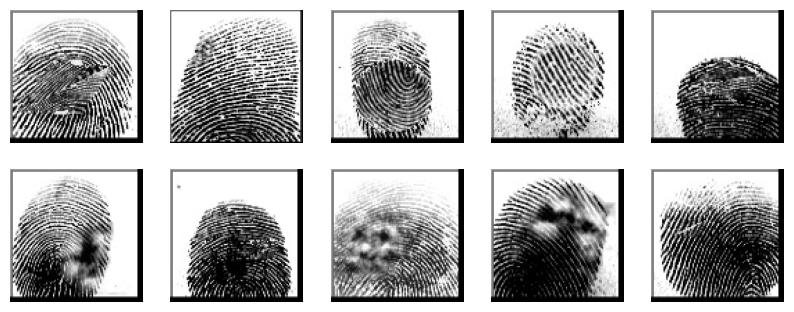

In [10]:
# show the first 10 images in the training dataset
from IPython.display import clear_output

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(10):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"), cmap='gray')
        #TODO update labels
        #plt.title(int[labels[i]])
        plt.axis("off")
        
clear_output()

## Apply augmentation

When you don't have a large image dataset or when your images are all set in a single direction like ours are, it's a good practice to artificially introduce sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping. This helps expose the model to different aspects of the training data and reduce over-fitting. 

Learn more https://www.tensorflow.org/tutorials/images/data_augmentation

In [11]:
data_augmentation = tf.keras.Sequential([

  # randomly rotates images during training
  tf.keras.layers.RandomRotation(
    # a float represented as fraction of 2 Pi, or a tuple of size 2 representing lower and upper bound for rotating clockwise and counter-clockwise. 
    # A positive values means rotating counter clock-wise, while a negative value means clock-wise. 
    0.2,
      
    # Points outside the boundaries of the input are filled according to the given mode (one of {"constant", "reflect", "wrap", "nearest"}).
    fill_mode='constant',
      
    # Supported values: "nearest", "bilinear".
    interpolation='nearest',
      
    # Integer. Used to create a random seed.
    seed=None,
      
    # the value to be filled outside the boundaries when fill_mode="constant".
    fill_value=0.0,
),
])

Visualize a few augmented examples by applying data augmentation to the same image several times:Visualize a few augmented examples by applying data augmentation to the same image several times:

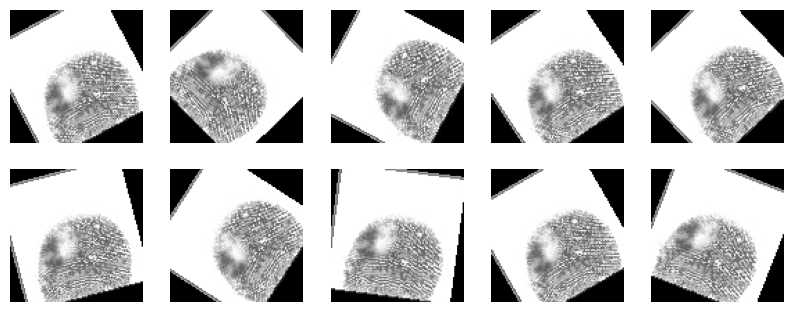

In [12]:
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[2]
  for i in range(10):
    ax = plt.subplot(5, 5, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 1, cmap='gray')
    plt.axis('off')
    
clear_output()

## Configure the datasets for performance

Let's make sure to use buffered prefetching so we can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data.

1. `Caching` a dataset, either in memory or on local storage. This will save some operations (like file opening and data reading) from being executed during each epoch.
1. `Prefetching` overlaps the preprocessing and model execution of a training step. While the model is executing training step s, the input pipeline is reading the data for step s+1. Doing so reduces the step time to the maximum (as opposed to the sum) of the training and the time it takes to extract the data.

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Training

## Define a training strategy 

tf.distribute.Strategy is a TensorFlow API to distribute training across multiple GPUs, multiple machines, or TPUs. Using this API, you can distribute your existing models and training code with minimal code changes.
- Easy to use and support multiple user segments, including researchers, machine learning engineers, etc.
- Provide good performance out of the box.
- Easy switching between strategies.

In [14]:
# display physical devices
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [15]:
# display logical devices
tf.config.list_logical_devices()

[LogicalDevice(name='/device:CPU:0', device_type='CPU'),
 LogicalDevice(name='/device:GPU:0', device_type='GPU')]

In [17]:
#  example, single device
#device="/cpu:0"
device="/GPU:0"

#  example, multiple devices devices
#device = ['/device:GPU:0', '/device:GPU:1', '/device:GPU:2', '/device:GPU:3']

### One Device Strategy

A distribution strategy for running on a single device. Device string identifier for the device on which the variables should be placed. See class docs for more details on how the device is used. Examples: "/cpu:0", "/gpu:0", "/device:CPU:0", "/device:GPU:0"

In [18]:
# uncomment to create a OneDeviceStrategy

strategy = tf.distribute.OneDeviceStrategy(device=device)

### Mirrored Strategy 

Supports synchronous distributed training on multiple GPUs on one machine. It creates one replica per GPU device. Each variable in the model is mirrored across all the replicas. 

In [19]:
# uncomment to create a MirroredStrategy

#strategy = tf.distribute.MirroredStrategy(devices=device)
#strategy = tf.distribute.MirroredStrategy()

### Multi-Worker Mirrored Strategy

Multi-Worker MirroredStrategy is very similar to MirroredStrategy. It implements synchronous distributed training across multiple workers, each with potentially multiple GPUs. Similar to tf.distribute.MirroredStrategy, it creates copies of all variables in the model on each device across all workers.

MultiWorkerMirroredStrategy has two implementations for cross-device communications. 
1. CommunicationImplementation.RING is RPC-based and supports both CPUs and GPUs. 
1. CommunicationImplementation.NCCL uses NCCL and provides state-of-art performance on GPUs but it doesn't support CPUs. 
1. CollectiveCommunication.AUTO defers the choice to Tensorflow. 

You can specify them in the following way:

In [ ]:
# uncomment to create a Multi-worker Mirrored Strategy

communication_options = tf.distribute.experimental.CommunicationOptions(
    # RING is RPC-based and supports both CPUs and GPUs.
    #implementation=tf.distribute.experimental.CommunicationImplementation.RING)

    # NCCL uses NCCL and provides state-of-art performance on GPUs but it doesn't support CPUs
    #implementation=tf.distribute.experimental.CommunicationImplementation.NCCL)
    
    # AUTO defers the choice to Tensorflow.
    implementation=tf.distribute.experimental.CommunicationImplementation.AUTO)

strategy = tf.distribute.MultiWorkerMirroredStrategy(communication_options=communication_options)

## Define a model and hyperparameters

When you build a model for hypertuning, you also define the hyperparameter search space in addition to the model architecture. The model you set up for hypertuning is called a hypermodel.

In [20]:
# build model from scratch
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Dropout,Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras import layers
from tensorflow import keras
import keras_tuner as kt

num_classes = len(class_names)

inputShape=(img_height, img_width, 1)
data_format="channels_last"

def model_builder(hp):
    model = keras.Sequential(name="fingerprint_prediction")
    # comment out to remove augmentation
    data_augmentation
    input_shape=(img_height, img_width, 1)
    chanDim = -1
    # first CONV => RELU => POOL layer set
    model.add(Conv2D(
        hp.Int("conv_1", min_value=32, max_value=96, step=32),
        (3, 3), padding="same", input_shape=inputShape, data_format=data_format))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # second CONV => RELU => POOL layer set
    model.add(Conv2D(
        hp.Int("conv_2", min_value=64, max_value=128, step=32),
        (3, 3), padding="same", data_format=data_format))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # third CONV => RELU => POOL layer set
    model.add(Conv2D(
        hp.Int("conv_3", min_value=96, max_value=256, step=32),
        (3, 3), padding="same", data_format=data_format))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))    
    
    # first (and only) set of FC => RELU layers
    model.add(Flatten())
    model.add(Dense(hp.Int("dense_units", min_value=256,
                           max_value=768, step=256)))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    # softmax classifier
    model.add(Dense(num_classes))
    model.add(Activation("softmax"))
    
    # initialize the learning rate choices and optimizer
    lr = hp.Choice("learning_rate",
                   values=[1e-1, 1e-2, 1e-3])
    # compile the model
    model.compile(optimizer='adam', loss="categorical_crossentropy",
                  metrics=["accuracy"])
    # return the model
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss=tf.losses.CategoricalCrossentropy(from_logits=False),
        # metrics to be evaluated by the model during training and testing.The strings 'accuracy' or 'acc', TF converts this to binary, categorical or sparse.
        metrics=['accuracy'],
    )
    return model

## Search hyperparameters

The Keras Tuner has four tuners available:
1. RandomSearch
1. Hyperband
1. BayesianOptimization
1. Sklearn. 

In this tutorial, you use the Hyperband tuner. 

The Hyperband tuning algorithm uses adaptive resource allocation and early-stopping to quickly converge on a high-performing model. This is done using a sports championship style bracket. The algorithm trains a large number of models for a few epochs and carries forward only the top-performing half of models to the next round. 

To instantiate the Hyperband tuner, you must specify the hypermodel, the objective to optimize and the maximum number of epochs to train (max_epochs).

In [21]:
num_classes = len(class_names)

# open a strategy scope
tuner = kt.Hyperband(
    model_builder,
    objective='val_accuracy',
    # Integer, the maximum number of epochs to train one model. It is recommended to set this to a value slightly higher than the expected epochs to convergence for your largest Model, and to use early stopping during training
    max_epochs=5,
    # Integer, the reduction factor for the number of epochs and number of models for each bracket. Defaults to 3.
    factor=3,
    # training strategy
    distribution_strategy=strategy,
    # directory to save the hyperparameter trials
    # TODO Update with a variable
    directory=scratch_path + '/tune/model_hp',
    # folder to save the hyperparameter trail outputs
    project_name='hypertune',
    #  If you re-run the hyperparameter search, the Keras Tuner uses the existing state from these logs to resume the search. 
    # To disable this behavior, pass an additional overwrite=True argument while instantiating the tuner.
    overwrite=True
)

We’ll be using EarlyStopping to short circuit hyperparameter trials that are not performing well. Keep in mind that tuning hyperparameters is an extremely computationally expensive process, so if we can kill off poorly performing trials, we can save ourselves a bunch of time.

In [22]:
# stop training when a monitored metric has stopped improving
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode="auto")

This search will run for 10 Trials.
- CPU: Best val_accuracy: 0.947070837020874  | Total elapsed time: 02h 11m 29s | Model: ?
- GPU: Best val_accuracy: 0.872768342494964  | Total elapsed time: 00h 08m 44s | Sagemaker - Instance Type: ?
- GPU: Best val_accuracy: 0.879129886627197  | Total elapsed time: 00h 59m 48s | Model: Tesla M10 (x4) | Driver Version: 525.60.13  |  CUDA Version: 12.0

The learned values will be around
```
[INFO] optimal number of filters in conv_1 layer: 32
[INFO] optimal number of filters in conv_2 layer: 96
[INFO] optimal number of filters in conv_3 layer: 160
[INFO] optimal number of units in dense layer: 512
[INFO] optimal learning rate: 0.0010
```

In [23]:
tuner.search(train_ds, epochs=4, validation_data=validation_ds, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print("[INFO] optimal number of filters in conv_1 layer: {}".format(
	best_hps.get("conv_1")))
print("[INFO] optimal number of filters in conv_2 layer: {}".format(
	best_hps.get("conv_2")))
print("[INFO] optimal number of filters in conv_3 layer: {}".format(
	best_hps.get("conv_3")))
print("[INFO] optimal number of units in dense layer: {}".format(
	best_hps.get("dense_units")))
print("[INFO] optimal learning rate: {:.4f}".format(
	best_hps.get("learning_rate")))


Search: Running Trial #1

Hyperparameter    |Value             |Best Value So Far 
conv_1            |96                |?                 
conv_2            |128               |?                 
conv_3            |256               |?                 
dense_units       |768               |?                 
learning_rate     |0.1               |?                 
tuner/epochs      |2                 |?                 
tuner/initial_e...|0                 |?                 
tuner/bracket     |1                 |?                 
tuner/round       |0                 |?                 

Epoch 1/2


2023-05-31 22:12:49.060963: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:784] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 12568
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:0"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_STRING
        }
      }
    }
  }
}

2023-05-31

ResourceExhaustedError: Graph execution error:

Detected at node 'fingerprint_prediction/activation/Relu' defined at (most recent call last):
    File "/usr/lib64/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/usr/lib64/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/opt/app-root/lib64/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/app-root/lib64/python3.9/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/opt/app-root/lib64/python3.9/site-packages/ipykernel/kernelapp.py", line 725, in start
      self.io_loop.start()
    File "/opt/app-root/lib64/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "/usr/lib64/python3.9/asyncio/base_events.py", line 601, in run_forever
      self._run_once()
    File "/usr/lib64/python3.9/asyncio/base_events.py", line 1905, in _run_once
      handle._run()
    File "/usr/lib64/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/app-root/lib64/python3.9/site-packages/ipykernel/kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "/opt/app-root/lib64/python3.9/site-packages/ipykernel/kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "/opt/app-root/lib64/python3.9/site-packages/ipykernel/kernelbase.py", line 409, in dispatch_shell
      await result
    File "/opt/app-root/lib64/python3.9/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/opt/app-root/lib64/python3.9/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/opt/app-root/lib64/python3.9/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/app-root/lib64/python3.9/site-packages/IPython/core/interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "/opt/app-root/lib64/python3.9/site-packages/IPython/core/interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "/opt/app-root/lib64/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/app-root/lib64/python3.9/site-packages/IPython/core/interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/app-root/lib64/python3.9/site-packages/IPython/core/interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/app-root/lib64/python3.9/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_5479/3074484213.py", line 1, in <module>
      tuner.search(train_ds, epochs=4, validation_data=validation_ds, callbacks=[stop_early])
    File "/opt/app-root/lib64/python3.9/site-packages/keras_tuner/engine/base_tuner.py", line 176, in search
      self.run_trial(trial, *fit_args, **fit_kwargs)
    File "/opt/app-root/lib64/python3.9/site-packages/keras_tuner/tuners/hyperband.py", line 370, in run_trial
      super(Hyperband, self).run_trial(trial, *fit_args, **fit_kwargs)
    File "/opt/app-root/lib64/python3.9/site-packages/keras_tuner/engine/multi_execution_tuner.py", line 90, in run_trial
      history = self._build_and_fit_model(trial, fit_args, copied_fit_kwargs)
    File "/opt/app-root/lib64/python3.9/site-packages/keras_tuner/engine/tuner.py", line 149, in _build_and_fit_model
      return model.fit(*fit_args, **fit_kwargs)
    File "/opt/app-root/lib64/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/app-root/lib64/python3.9/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/app-root/lib64/python3.9/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/opt/app-root/lib64/python3.9/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/app-root/lib64/python3.9/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/opt/app-root/lib64/python3.9/site-packages/keras/engine/training.py", line 1023, in train_step
      y_pred = self(x, training=True)
    File "/opt/app-root/lib64/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/app-root/lib64/python3.9/site-packages/keras/engine/training.py", line 561, in __call__
      return super().__call__(*args, **kwargs)
    File "/opt/app-root/lib64/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/app-root/lib64/python3.9/site-packages/keras/engine/base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/opt/app-root/lib64/python3.9/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/opt/app-root/lib64/python3.9/site-packages/keras/engine/sequential.py", line 413, in call
      return super().call(inputs, training=training, mask=mask)
    File "/opt/app-root/lib64/python3.9/site-packages/keras/engine/functional.py", line 511, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/opt/app-root/lib64/python3.9/site-packages/keras/engine/functional.py", line 668, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/opt/app-root/lib64/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/app-root/lib64/python3.9/site-packages/keras/engine/base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/opt/app-root/lib64/python3.9/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/opt/app-root/lib64/python3.9/site-packages/keras/layers/core/activation.py", line 59, in call
      return self.activation(inputs)
    File "/opt/app-root/lib64/python3.9/site-packages/keras/activations.py", line 317, in relu
      return backend.relu(
    File "/opt/app-root/lib64/python3.9/site-packages/keras/backend.py", line 5369, in relu
      x = tf.nn.relu(x)
Node: 'fingerprint_prediction/activation/Relu'
OOM when allocating tensor with shape[32,96,96,96] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node fingerprint_prediction/activation/Relu}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_12451]

## Fit a model

Fit the model with the optimal hyperparameters and train it on the data for a desired number of epochs. This training cycle will run for 9 epochs resulting in an accuracy around ~0.98 accuracy


In [ ]:
epochs = 8

model = tuner.hypermodel.build(best_hps)
history = model.fit(
    train_ds,
    batch_size=batch_size,
    validation_data=validation_ds,
    epochs=epochs,
    workers=1,
    use_multiprocessing=False
)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

## Print the model layers

In [ ]:
model.summary()

## Evaluate the model

Should get an accuracy around 0.96

In [ ]:
model.evaluate(
    test_ds,
    batch_size=batch_size,
    verbose='auto',
    sample_weight=None,
    steps=None,
    callbacks=None,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=False
)

# Save the model

A SavedModel is a directory containing serialized signatures and the state needed to run them, including variable values and vocabularies.

```
assets            directory contains files used by the TensorFlow graph
keras_metadata.pb file  
saved_model.pb    file stores the actual TensorFlow program, or model, and a set of named signatures for tensor I/O
variables         directory contains a standard training checkpoint 
```

There are 2 formats you can use to save an entire model to disk, the TensorFlow SavedModel format and the older Keras H5 format.

For versioning, you typically generate several models made up of (code, data, config) that demands model versioning. 

`/parent-folder/project-name/VERSION_NUMBER/MAJOR.MINOR.PIPELINE.tf`

Triton expects the following folder structure:

`/parent-folder/project-name/VERSION_NUMBER/model.savedmodel`

* `parent-folder` should be the root of s3 url, ex: `s3://bucket/parent-folder`

## Save locally

Triton MUST have the model artifacts as `model.savedmodel`

In [ ]:
# SET model version MAJOR.MINOR
%env VERSION=1
%env LITE_VERSION=1.1

model_version = os.environ.get('VERSION', "1")
lite_version = os.environ.get('LITE_VERSION', "1.1")

In [ ]:
# note: tf.saved_model.save(model, path_to_dir)
model_path = "../models/fingerprint/" + model_version + "/model.savedmodel"
model.save(model_path)

## Convert to TensorFlow Lite model

TensorFlow Lite is a set of tools that enables on-device machine learning by helping developers run their models on mobile, embedded, and edge devices.

To use the trained model with on-device applications, first convert it to a smaller and more efficient model format called a TensorFlow Lite model. To continue exploration with TFLite models [see this tutorial from TensorFlow](https://www.tensorflow.org/lite/models/modify/model_maker/image_classification#simple_end-to-end_example).

In [ ]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

tflite_path = "../models/fingerprint/" + lite_version

if not os.path.exists(tflite_path):
    os.makedirs(tflite_path)
    
# Save the model.
with open(tflite_path + "/model.tflite", 'wb') as f:
  f.write(tflite_model)

# Make a prediction

## Load the full model

In [ ]:
model_path = "../models/fingerprint/" + model_version + "/model.savedmodel"
model = keras.models.load_model(model_path)

### Load a new fingerprint

### Convert the image

In [ ]:
# select random images
import random

samples_path = scratch_path + '/real/'
file_list = os.listdir(samples_path)
print('Files in path: ' + str(len(file_list)))

test_image = random.choice(file_list)
print('Selected: ' + test_image)

# loads an image into PIL format.
img = tf.keras.utils.load_img(
    samples_path + test_image,
    color_mode="grayscale",
    target_size=(img_height, img_width),
    interpolation='nearest',
)

plt.imshow(img, cmap='gray')

# converts a PIL image instance to a numpy array
img_array = tf.keras.utils.img_to_array(img)
print("shape:",img_array.shape)
print("shape:",img_array.dtype)
print("shape:",img_array.size)

img_array = tf.expand_dims(img_array, 0)

### Predict

In [ ]:
# perform a prediction on the new fingerprint
predictions = model.predict(img_array)

In [ ]:
import numpy as np

score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)